# Taxi fare prediction

In [60]:
import requests as re
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
%matplotlib inline

### Downloading and loading data

In [11]:
URL = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/yellow_tripdata_2019-06.csv'
response = re.get(URL)
if response.status_code == 200:
    with open('taxi-fare.csv', 'wb') as file:
            file.write(response.content)

sucs


In [47]:
df = pd.read_csv('taxi-fare.csv')
df.shape

(3936004, 18)

In [48]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1,2019-06-01 00:55:13,2019-06-01 00:56:17,1.0,0.0,1.0,N,145.0,145.0,2.0,3.0,0.5,0.5,0.00,0.0,0.3,4.30,0.0
1,1,2019-06-01 00:06:31,2019-06-01 00:06:52,1.0,0.0,1.0,N,262.0,263.0,2.0,2.5,3.0,0.5,0.00,0.0,0.3,6.30,2.5
2,1,2019-06-01 00:17:05,2019-06-01 00:36:38,1.0,4.4,1.0,N,74.0,7.0,2.0,17.5,0.5,0.5,0.00,0.0,0.3,18.80,0.0
3,1,2019-06-01 00:59:02,2019-06-01 00:59:12,0.0,0.8,1.0,N,145.0,145.0,2.0,2.5,1.0,0.5,0.00,0.0,0.3,4.30,0.0
4,1,2019-06-01 00:03:25,2019-06-01 00:15:42,1.0,1.7,1.0,N,113.0,148.0,1.0,9.5,3.0,0.5,2.65,0.0,0.3,15.95,2.5


### Cleaning DS

In [49]:
df = df[df['tip_amount'] > 0]
df = df[df['tip_amount'] <= df['fare_amount']]
df = df[((df['fare_amount'] >=2) & (df['fare_amount'] < 200))]
clean_df= df.drop(['total_amount'], axis=1)

del df

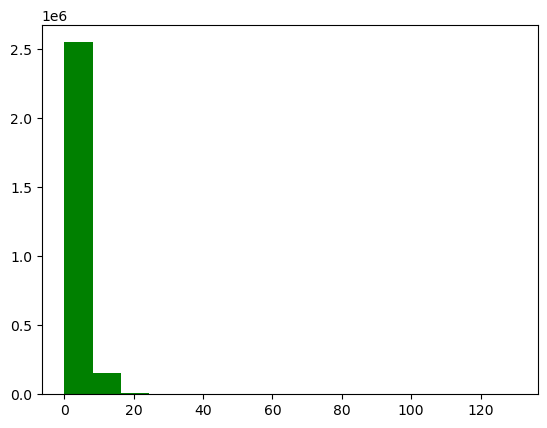

In [50]:
plt.hist(clean_df.tip_amount.values, 16, histtype='bar', facecolor='g')
plt.show()

In [51]:
clean_df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge
4,1,2019-06-01 00:03:25,2019-06-01 00:15:42,1.0,1.70,1.0,N,113.0,148.0,1.0,9.5,3.0,0.5,2.65,0.0,0.3,2.5
5,1,2019-06-01 00:28:31,2019-06-01 00:39:23,2.0,1.60,1.0,N,79.0,125.0,1.0,9.5,3.0,0.5,1.00,0.0,0.3,2.5
7,1,2019-06-01 00:54:49,2019-06-01 01:02:57,2.0,1.20,1.0,N,79.0,249.0,1.0,7.5,3.0,0.5,1.00,0.0,0.3,2.5
9,1,2019-06-01 00:29:12,2019-06-01 01:03:13,1.0,8.60,1.0,N,186.0,243.0,1.0,31.5,3.0,0.5,7.05,0.0,0.3,2.5
10,2,2019-06-01 00:01:48,2019-06-01 00:16:06,1.0,1.74,1.0,N,107.0,148.0,1.0,11.0,0.5,0.5,2.96,0.0,0.3,2.5


### Pre-processing

In [52]:
clean_df['tpep_dropoff_datetime'] = pd.to_datetime(clean_df['tpep_dropoff_datetime'])
clean_df['tpep_pickup_datetime'] = pd.to_datetime(clean_df['tpep_dropoff_datetime'])

clean_df['pickup_hour'] = clean_df['tpep_pickup_datetime'].dt.hour
clean_df['dropoff_hour'] = clean_df['tpep_dropoff_datetime'].dt.hour

clean_df['pickup_day'] = clean_df['tpep_pickup_datetime'].dt.weekday
clean_df['dropoff_day'] = clean_df['tpep_dropoff_datetime'].dt.weekday

clean_df['trip_time'] = (clean_df['tpep_pickup_datetime'] - clean_df['tpep_dropoff_datetime']).dt.total_seconds()

#dealing with memory leak in this study
first_n_rows = 200000
clean_df = clean_df.head(first_n_rows)

In [53]:
clean_df = clean_df.drop(columns=['tpep_pickup_datetime', 'tpep_dropoff_datetime'], axis=1)

In [54]:
get_dummy_col = ["VendorID","RatecodeID","store_and_fwd_flag","PULocationID", "DOLocationID","payment_type", "pickup_hour", "dropoff_hour", "pickup_day", "dropoff_day"]
proc_data = pd.get_dummies(clean_df, columns = get_dummy_col)
del clean_df

In [55]:
y = proc_data[['tip_amount']].values.astype('float32')
proc_data = proc_data.drop(['tip_amount'], axis=1)

X = proc_data.values
X = normalize(X, axis=1, norm='l1', copy=False)
print('X.shape=', X.shape, 'y.shape=', y.shape)

X.shape= (200000, 516) y.shape= (200000, 1)


In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print('X_train.shape=', X_train.shape, 'Y_train.shape=', y_train.shape)
print('X_test.shape=', X_test.shape, 'Y_test.shape=', y_test.shape)

X_train.shape= (140000, 516) Y_train.shape= (140000, 1)
X_test.shape= (60000, 516) Y_test.shape= (60000, 1)


In [58]:
from sklearn.tree import DecisionTreeRegressor
sklearn_dt = DecisionTreeRegressor(max_depth=8, random_state=35)

t0 = time.time()
sklearn_dt.fit(X_train, y_train)
sklearn_time = time.time()-t0
print("[Scikit-Learn] Training time (s):  {0:.5f}".format(sklearn_time))

[Scikit-Learn] Training time (s):  13.71760


In [61]:
sklearn_pred = sklearn_dt.predict(X_test)
sklearn_mse = mean_squared_error(y_test, sklearn_pred)
print('[Scikit-Learn] MSE score : {0:.3f}'.format(sklearn_mse))

[Scikit-Learn] MSE score : 1.632
